# Импорт библиотек

In [9]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
import warnings

warnings.filterwarnings("ignore")

# Задача классификации

In [11]:
df = pd.read_csv('bank-full.csv', sep=';')
df.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,58,management,married,tertiary,no,2143,yes,no,unknown,5,may,261,1,-1,0,unknown,no
1,44,technician,single,secondary,no,29,yes,no,unknown,5,may,151,1,-1,0,unknown,no
2,33,entrepreneur,married,secondary,no,2,yes,yes,unknown,5,may,76,1,-1,0,unknown,no
3,47,blue-collar,married,unknown,no,1506,yes,no,unknown,5,may,92,1,-1,0,unknown,no
4,33,unknown,single,unknown,no,1,no,no,unknown,5,may,198,1,-1,0,unknown,no


Посмотрим, че ваще за данные и что по пропускам

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45211 entries, 0 to 45210
Data columns (total 17 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   age        45211 non-null  int64 
 1   job        45211 non-null  object
 2   marital    45211 non-null  object
 3   education  45211 non-null  object
 4   default    45211 non-null  object
 5   balance    45211 non-null  int64 
 6   housing    45211 non-null  object
 7   loan       45211 non-null  object
 8   contact    45211 non-null  object
 9   day        45211 non-null  int64 
 10  month      45211 non-null  object
 11  duration   45211 non-null  int64 
 12  campaign   45211 non-null  int64 
 13  pdays      45211 non-null  int64 
 14  previous   45211 non-null  int64 
 15  poutcome   45211 non-null  object
 16  y          45211 non-null  object
dtypes: int64(7), object(10)
memory usage: 5.9+ MB


Сделаем копию данных, которые останутся неподготовленными

In [13]:
df_only_encoded = df.copy()

Закодируем признаки, чтобы модель не ругалася на то, что мы в него не числа пихаем

In [14]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                    'loan', 'contact', 'month', 'poutcome']

for col in categorical_cols:
    le = LabelEncoder()
    df_only_encoded[col] = le.fit_transform(df_only_encoded[col])
    label_encoders[col] = le

le_target = LabelEncoder()
df_only_encoded['y'] = le_target.fit_transform(df_only_encoded['y'])

собственно разделение на трейт, тест и обучение

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

X = df_only_encoded.drop('y', axis=1)
y = df_only_encoded['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

tree = RandomForestClassifier()
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-мера:", f1_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9062258100187991
F1-мера: 0.5103926096997691

Confusion Matrix:
[[7753  232]
 [ 616  442]]


Кастомная имплементация

In [16]:
import numpy as np
from collections import Counter
from typing import Tuple, Optional, Union, List
import random

class Node:
    def __init__(self,
                 feature_idx: Optional[int] = None,
                 threshold: Optional[float] = None,
                 left: Optional['Node'] = None,
                 right: Optional['Node'] = None,
                 value: Optional[Union[int, float]] = None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value

class CustomDecisionTreeClassifier:
    def __init__(self,
                 max_depth: int = 5,
                 min_samples_split: int = 2,
                 criterion: str = 'gini',
                 max_features: Optional[int] = None):

        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.criterion = criterion
        self.max_features = max_features
        self.root = None
        self.n_classes_ = None
        self.n_features_ = None

    def _gini(self, y: np.ndarray) -> float:
        proportions = np.bincount(y) / len(y)
        gini = 1 - np.sum(proportions ** 2)
        return gini

    def _entropy(self, y: np.ndarray) -> float:
        proportions = np.bincount(y) / len(y)
        proportions = proportions[proportions > 0]
        entropy = -np.sum(proportions * np.log2(proportions))
        return entropy

    def _information_gain(self,
                         y: np.ndarray,
                         left_idx: np.ndarray,
                         right_idx: np.ndarray,
                         criterion: str) -> float:
        n = len(y)

        if criterion == 'gini':
            impurity_func = self._gini
        else:
            impurity_func = self._entropy

        parent_impurity = impurity_func(y)

        n_left = len(left_idx)
        n_right = len(right_idx)

        if n_left == 0 or n_right == 0:
            return 0

        child_impurity = (n_left / n) * impurity_func(y[left_idx]) + \
                         (n_right / n) * impurity_func(y[right_idx])

        return parent_impurity - child_impurity

    def _find_best_split(self,
                        X: np.ndarray,
                        y: np.ndarray) -> Tuple[int, float, float]:
        n_samples, n_features = X.shape
        best_gain = -1
        best_feature_idx = -1
        best_threshold = None

        if self.max_features is None:
            features_to_consider = list(range(n_features))
        else:
            features_to_consider = np.random.choice(
                n_features,
                size=min(self.max_features, n_features),
                replace=False
            )

        for feature_idx in features_to_consider:
            feature_values = np.unique(X[:, feature_idx])

            for threshold in feature_values:
                left_idx = np.where(X[:, feature_idx] <= threshold)[0]
                right_idx = np.where(X[:, feature_idx] > threshold)[0]

                if len(left_idx) < self.min_samples_split or \
                   len(right_idx) < self.min_samples_split:
                    continue

                gain = self._information_gain(y, left_idx, right_idx, self.criterion)

                if gain > best_gain:
                    best_gain = gain
                    best_feature_idx = feature_idx
                    best_threshold = threshold

        return best_feature_idx, best_threshold, best_gain

    def _build_tree(self,
                   X: np.ndarray,
                   y: np.ndarray,
                   depth: int = 0) -> Node:
        n_samples = X.shape[0]

        if (depth >= self.max_depth or
            n_samples < self.min_samples_split or
            len(np.unique(y)) == 1):
            leaf_value = self._calculate_leaf_value(y)
            return Node(value=leaf_value)

        feature_idx, threshold, gain = self._find_best_split(X, y)

        if gain == -1 or feature_idx == -1:
            leaf_value = self._calculate_leaf_value(y)
            return Node(value=leaf_value)

        left_idx = np.where(X[:, feature_idx] <= threshold)[0]
        right_idx = np.where(X[:, feature_idx] > threshold)[0]

        left_subtree = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right_subtree = self._build_tree(X[right_idx], y[right_idx], depth + 1)

        return Node(feature_idx=feature_idx,
                    threshold=threshold,
                    left=left_subtree,
                    right=right_subtree)

    def _calculate_leaf_value(self, y: np.ndarray) -> Union[int, float]:
        counter = Counter(y)
        most_common = counter.most_common(1)[0][0]
        return most_common

    def fit(self, X: np.ndarray, y: np.ndarray):
        X = np.array(X)
        y = np.array(y).astype(int)

        self.n_samples_, self.n_features_ = X.shape
        self.n_classes_ = len(np.unique(y))

        self.root = self._build_tree(X, y)
        return self

    def _predict_single(self, x: np.ndarray, node: Node) -> Union[int, float]:
        if node.value is not None:
            return node.value

        if x[node.feature_idx] <= node.threshold:
            return self._predict_single(x, node.left)
        else:
            return self._predict_single(x, node.right)

    def predict(self, X: np.ndarray) -> np.ndarray:
        X = np.array(X)
        predictions = [self._predict_single(x, self.root) for x in X]
        return np.array(predictions)

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        X = np.array(X)
        predictions = self.predict(X)
        proba = np.zeros((X.shape[0], self.n_classes_))

        for i, pred in enumerate(predictions):
            proba[i, pred] = 1.0

        return proba

    def get_depth(self, node: Optional[Node] = None) -> int:
        if node is None:
            node = self.root

        if node.value is not None:
            return 0

        left_depth = self.get_depth(node.left)
        right_depth = self.get_depth(node.right)

        return 1 + max(left_depth, right_depth)


class CustomRandomForestClassifier:
    def __init__(self,
                 n_estimators: int = 100,
                 max_depth: int = 5,
                 min_samples_split: int = 2,
                 max_samples: Optional[float] = None,
                 max_features: Optional[int] = None,
                 bootstrap: bool = True,
                 random_state: Optional[int] = None):

        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_samples = max_samples
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.trees = []
        self.n_classes_ = None
        self.n_features_ = None

        if random_state is not None:
            np.random.seed(random_state)
            random.seed(random_state)

    def _bootstrap_sample(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        n_samples = X.shape[0]
        if self.max_samples is not None:
            sample_size = int(self.max_samples * n_samples)
        else:
            sample_size = n_samples

        indices = np.random.choice(n_samples, size=sample_size, replace=self.bootstrap)
        return X[indices], y[indices]

    def fit(self, X: np.ndarray, y: np.ndarray):
        X = np.array(X)
        y = np.array(y).astype(int)

        self.n_features_ = X.shape[1]
        self.n_classes_ = len(np.unique(y))

        self.trees = []

        for i in range(self.n_estimators):
            X_sample, y_sample = self._bootstrap_sample(X, y)

            tree = CustomDecisionTreeClassifier(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                max_features=self.max_features
            )

            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        X = np.array(X)
        n_samples = X.shape[0]

        all_predictions = np.zeros((n_samples, self.n_estimators), dtype=int)

        for i, tree in enumerate(self.trees):
            all_predictions[:, i] = tree.predict(X)

        final_predictions = np.zeros(n_samples, dtype=int)

        for j in range(n_samples):
            votes = all_predictions[j, :]
            most_common = Counter(votes).most_common(1)[0][0]
            final_predictions[j] = most_common

        return final_predictions

    def predict_proba(self, X: np.ndarray) -> np.ndarray:
        X = np.array(X)
        n_samples = X.shape[0]

        proba = np.zeros((n_samples, self.n_classes_))

        for tree in self.trees:
            tree_proba = tree.predict_proba(X)
            proba += tree_proba

        proba /= self.n_estimators

        return proba

Обучим кастомную реализацию

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


tree = CustomRandomForestClassifier()
tree.fit(X_train, y_train)
y_pred = tree.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-мера:", f1_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9030189096538759
F1-мера: 0.48862973760932943

Confusion Matrix:
[[7747  238]
 [ 639  419]]


Сделаем копию данных, с которыми уже будем работать

In [19]:
df_with_eda = df.copy()

Глянем на пропуски

In [20]:
print("Пропущенные значения:")
print(df_with_eda.isnull().sum())

Пропущенные значения:
age          0
job          0
marital      0
education    0
default      0
balance      0
housing      0
loan         0
contact      0
day          0
month        0
duration     0
campaign     0
pdays        0
previous     0
poutcome     0
y            0
dtype: int64


Посмотрим на распределения

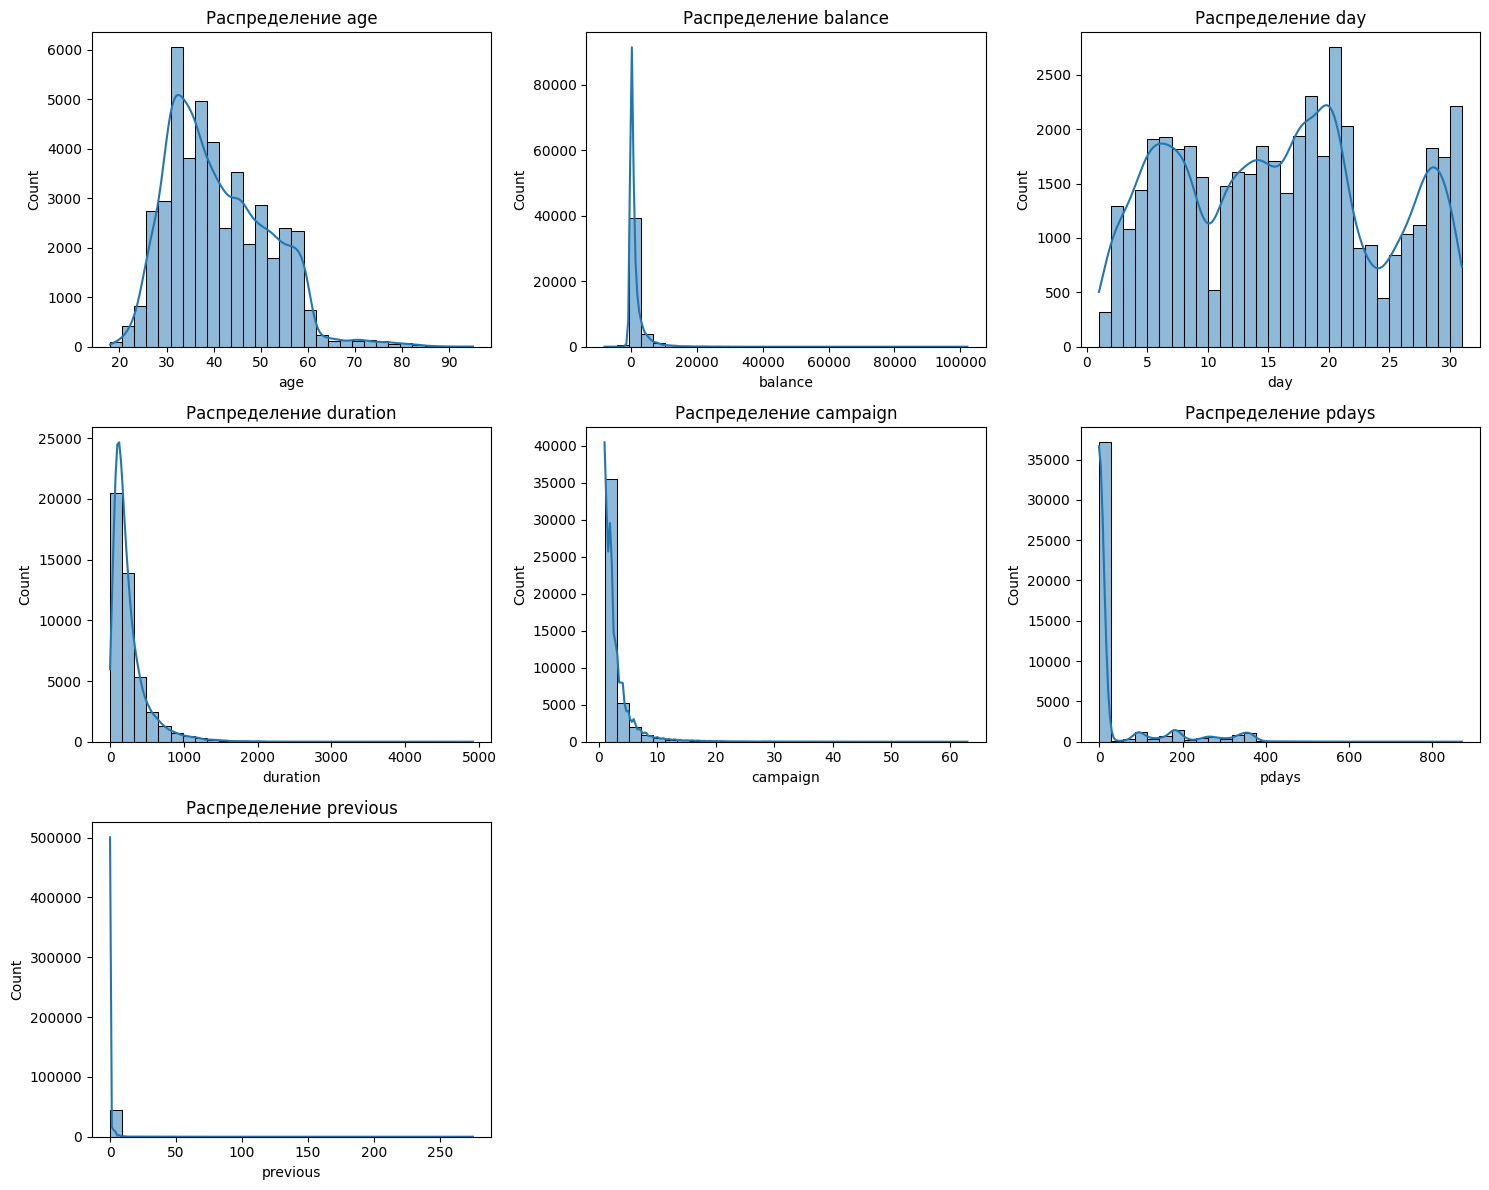

In [21]:
numeric_cols = ['age', 'balance', 'day', 'duration', 'campaign', 'pdays', 'previous']

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    sns.histplot(df_with_eda[col], kde=True, ax=axes[idx], bins=30)
    axes[idx].set_title(f'Распределение {col}')
    axes[idx].set_xlabel(col)

# Удаляем лишние оси
for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

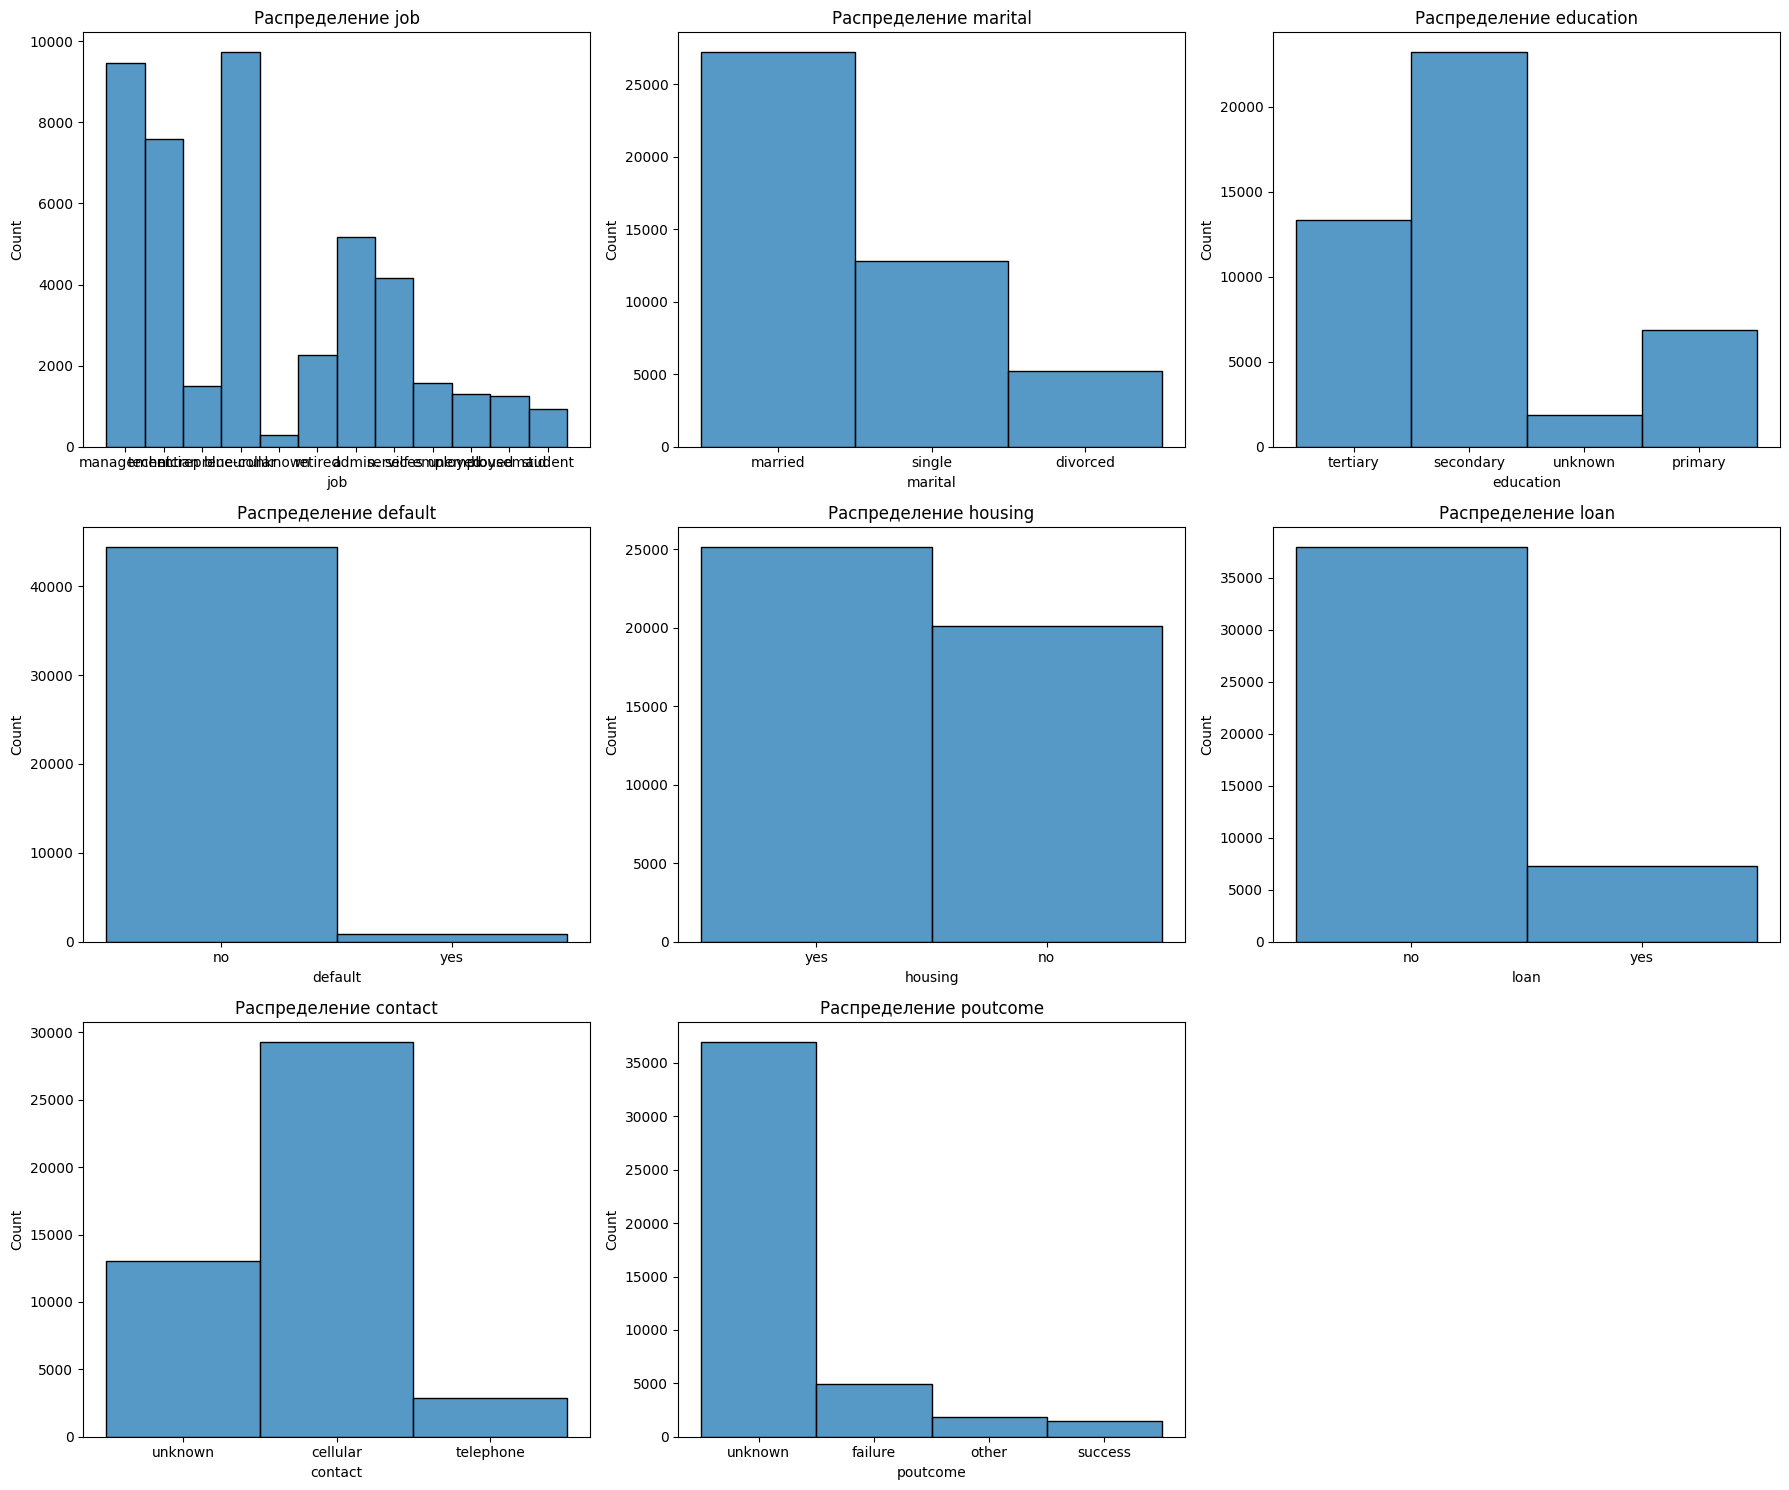

In [22]:
categorical_cols = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']

fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.flatten()

for idx, col in enumerate(categorical_cols):
    sns.histplot(df[col], kde=False, ax=axes[idx], bins=30)
    axes[idx].set_title(f'Распределение {col}')
    axes[idx].set_xlabel(col)


for idx in range(len(categorical_cols), len(axes)):
    fig.delaxes(axes[idx])


plt.tight_layout()
plt.show()

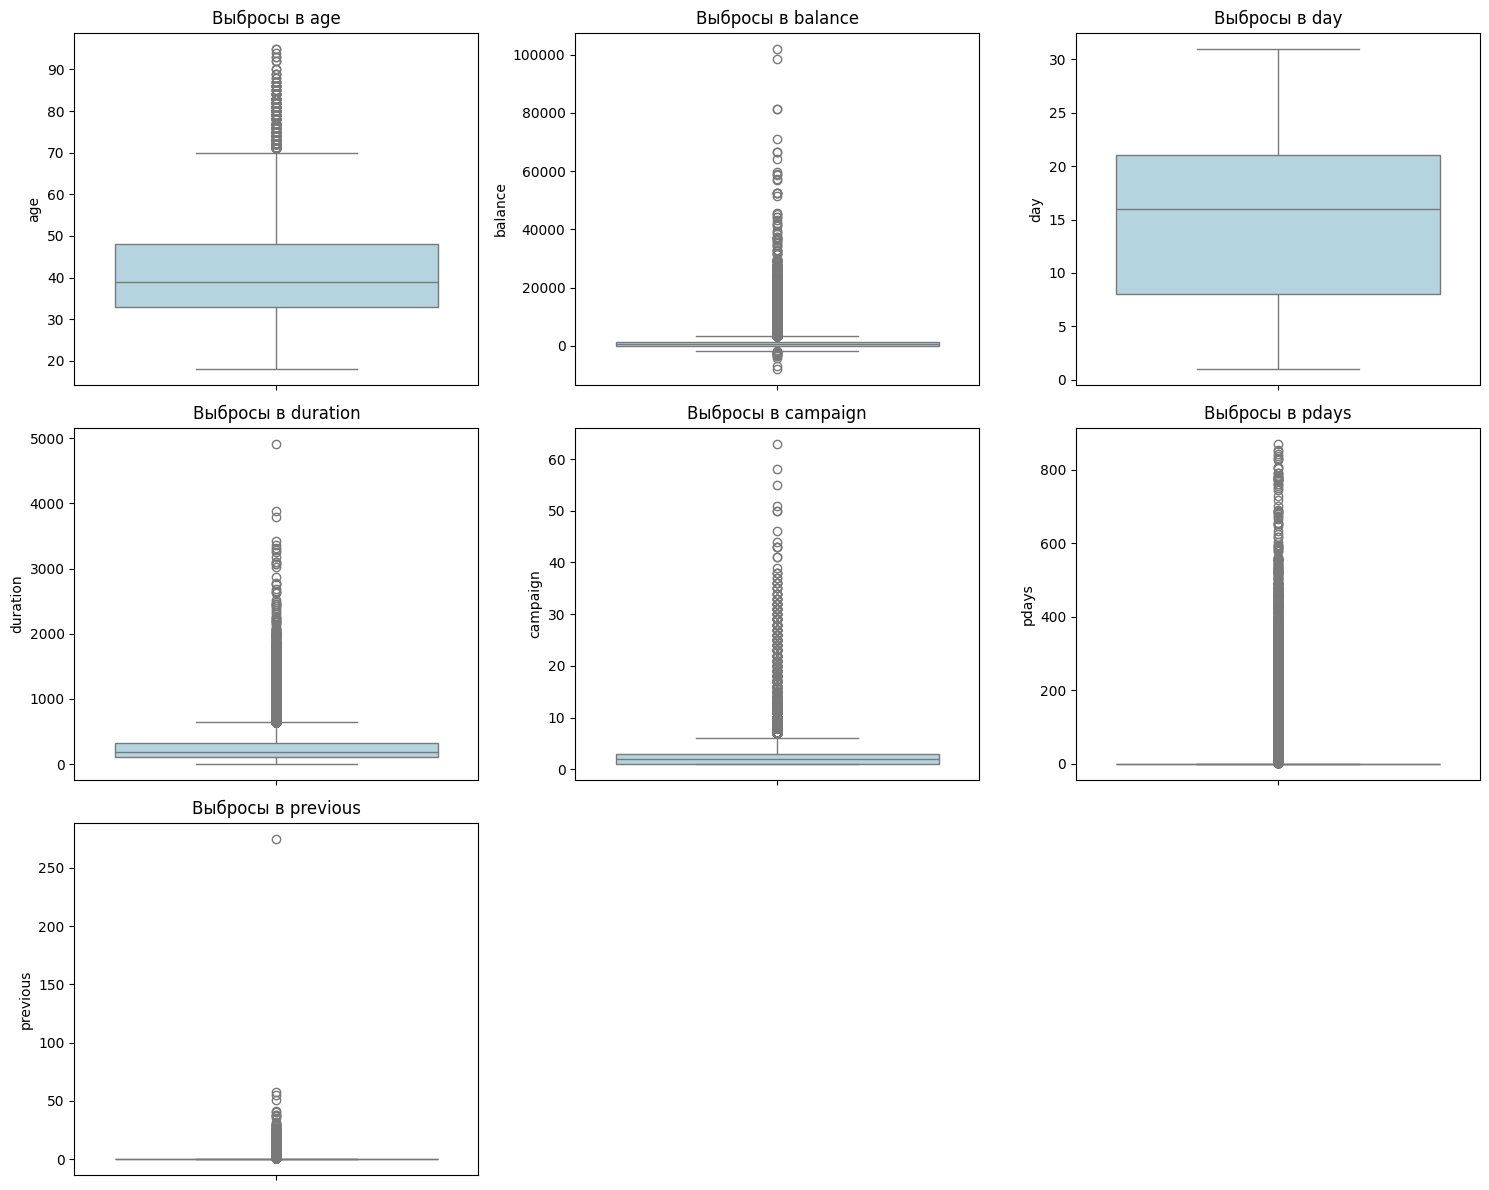

In [23]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    sns.boxplot(y=df_with_eda[col], ax=axes[idx], color='lightblue')
    axes[idx].set_title(f'Выбросы в {col}')
    axes[idx].set_ylabel(col)

for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

Уберем выбросы в балансе пользователей

In [24]:
Q1 = df_with_eda['balance'].quantile(0.25)
Q3 = df_with_eda['balance'].quantile(0.75)
IQR = Q3 - Q1
upper_bound = Q3 + 1.5 * IQR

df_with_eda['balance'] = np.where(df_with_eda['balance'] > upper_bound, upper_bound, df_with_eda['balance'])

Прологарифмируем некоторые признаки, чтобы приблизить их к нормальному распределению

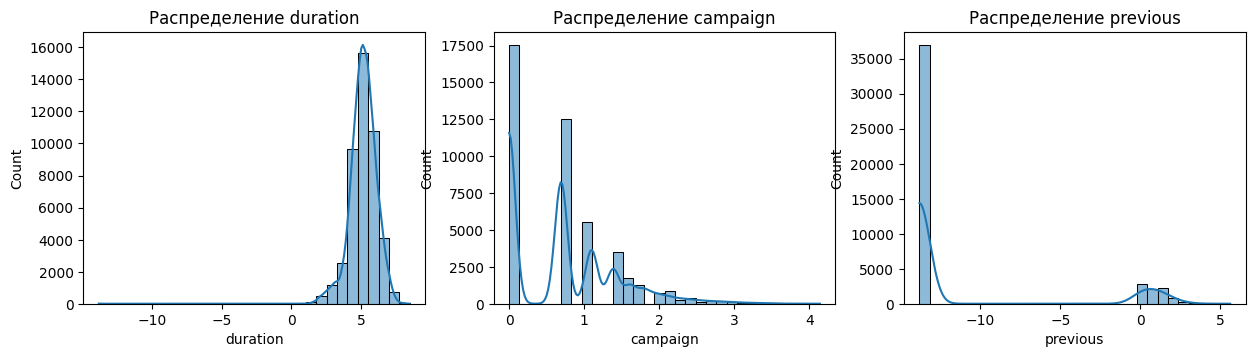

In [25]:
cols_to_log = ['duration', 'campaign', 'previous']

for col in cols_to_log:
  df_with_eda[col] = np.log(df_with_eda[col] + 1e-6)

fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(cols_to_log):
    sns.histplot(df_with_eda[col], kde=True, ax=axes[idx], bins=30)
    axes[idx].set_title(f'Распределение {col}')
    axes[idx].set_xlabel(col)

# Удаляем лишние оси
for idx in range(len(cols_to_log), len(axes)):
    fig.delaxes(axes[idx])

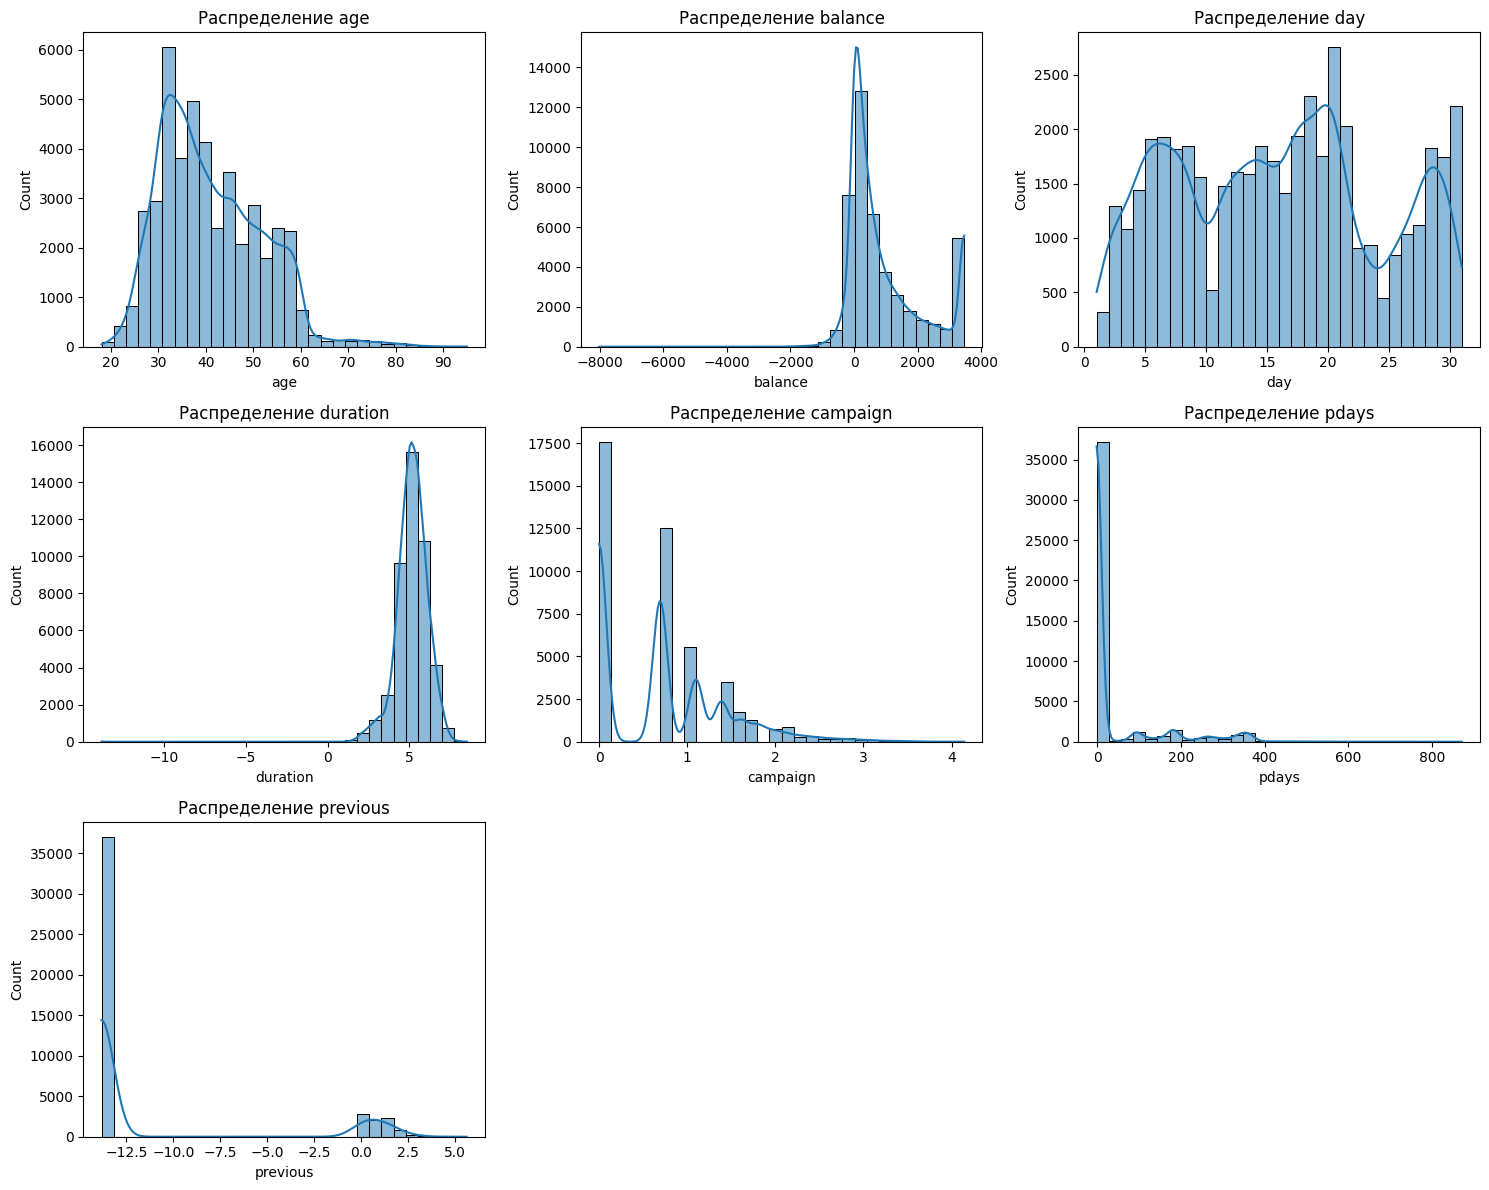

In [26]:
fig, axes = plt.subplots(3, 3, figsize=(15, 12))
axes = axes.flatten()

for idx, col in enumerate(numeric_cols):
    sns.histplot(df_with_eda[col], kde=True, ax=axes[idx], bins=30)
    axes[idx].set_title(f'Распределение {col}')
    axes[idx].set_xlabel(col)

# Удаляем лишние оси
for idx in range(len(numeric_cols), len(axes)):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

Снова кодируем все, что категориальное

In [27]:
from sklearn.preprocessing import LabelEncoder

label_encoders = {}
categorical_cols = ['job', 'marital', 'education', 'default', 'housing',
                    'loan', 'contact', 'month', 'poutcome']

for col in categorical_cols:
    le = LabelEncoder()
    df_with_eda[col] = le.fit_transform(df_with_eda[col])
    label_encoders[col] = le

le_target = LabelEncoder()
df_with_eda['y'] = le_target.fit_transform(df_with_eda['y'])

In [28]:
df_with_eda['pdays']

,pdays
0,-1
1,-1
2,-1
3,-1
4,-1
...,...
45206,-1
45207,-1
45208,184
45209,-1


обучим свою и сайкитлерновскую реализации

In [29]:
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

X = df_with_eda.drop('y', axis=1)
y = df_with_eda['y']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

tree = RandomForestClassifier()
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-мера:", f1_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9053411478491651
F1-мера: 0.5

Confusion Matrix:
[[7759  226]
 [ 630  428]]


In [31]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

tree = CustomRandomForestClassifier()
tree.fit(X_train, y_train)

y_pred = tree.predict(X_test)

print("Accuracy:", accuracy_score(y_test, y_pred))
print("F1-мера:", f1_score(y_test, y_pred))
print("\nConfusion Matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.9041247373659184
F1-мера: 0.49029982363315694

Confusion Matrix:
[[7759  226]
 [ 641  417]]


# Задача регрессии


In [32]:
df_reg = pd.read_csv('uber.csv')
df_reg.head()

,Unnamed: 0,key,fare_amount,pickup_datetime,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,passenger_count
0,24238194,2015-05-07 19:52:06.0000003,7.5,2015-05-07 19:52:06 UTC,-73.999817,40.738354,-73.999512,40.723217,1
1,27835199,2009-07-17 20:04:56.0000002,7.7,2009-07-17 20:04:56 UTC,-73.994355,40.728225,-73.994710,40.750325,1
2,44984355,2009-08-24 21:45:00.00000061,12.9,2009-08-24 21:45:00 UTC,-74.005043,40.740770,-73.962565,40.772647,1
3,25894730,2009-06-26 08:22:21.0000001,5.3,2009-06-26 08:22:21 UTC,-73.976124,40.790844,-73.965316,40.803349,3
4,17610152,2014-08-28 17:47:00.000000188,16.0,2014-08-28 17:47:00 UTC,-73.925023,40.744085,-73.973082,40.761247,5


убираем мусор

In [33]:
df_reg.drop(columns=['Unnamed: 0', 'key'], inplace=True)

In [34]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200000 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        200000 non-null  float64
 1   pickup_datetime    200000 non-null  object 
 2   pickup_longitude   200000 non-null  float64
 3   pickup_latitude    200000 non-null  float64
 4   dropoff_longitude  199999 non-null  float64
 5   dropoff_latitude   199999 non-null  float64
 6   passenger_count    200000 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 10.7+ MB


один пропуск тоже депортируем

In [35]:
df_reg = df_reg[df_reg['dropoff_latitude'].isna() == False]

In [36]:
df_reg.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199999 entries, 0 to 199999
Data columns (total 7 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   fare_amount        199999 non-null  float64
 1   pickup_datetime    199999 non-null  object 
 2   pickup_longitude   199999 non-null  float64
 3   pickup_latitude    199999 non-null  float64
 4   dropoff_longitude  199999 non-null  float64
 5   dropoff_latitude   199999 non-null  float64
 6   passenger_count    199999 non-null  int64  
dtypes: float64(5), int64(1), object(1)
memory usage: 12.2+ MB


In [37]:
df_prep = df_reg.copy()
df_not_prep = df_reg.copy()

сразу обучаем

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

X_reg = df_not_prep.drop(['fare_amount', 'pickup_datetime'], axis=1)
y_reg = df_not_prep['fare_amount']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

tree_reg = RandomForestRegressor()
tree_reg.fit(X_train_reg, y_train_reg)

y_pred_reg = tree_reg.predict(X_test_reg)

print("Regressor Evaluation:")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test_reg, y_pred_reg):.2f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)):.2f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test_reg, y_pred_reg):.2f}")
print(f"R-squared (R2): {r2_score(y_test_reg, y_pred_reg):.2f}")

Regressor Evaluation:
Mean Squared Error (MSE): 30.83
Root Mean Squared Error (RMSE): 5.55
Mean Absolute Error (MAE): 2.30
R-squared (R2): 0.70


кастомная реализация регрессора

In [39]:
import numpy as np
from collections import Counter
from typing import Tuple, Optional, Union, List
import random

class Node:
    def __init__(self,
                 feature_idx: Optional[int] = None,
                 threshold: Optional[float] = None,
                 left: Optional['Node'] = None,
                 right: Optional['Node'] = None,
                 value: Optional[Union[int, float]] = None):
        self.feature_idx = feature_idx
        self.threshold = threshold
        self.left = left
        self.right = right
        self.value = value


class CustomDecisionTreeRegressor:
    def __init__(self,
                 max_depth: int = 5,
                 min_samples_split: int = 2,
                 max_features: Optional[int] = None):

        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_features = max_features
        self.root = None
        self.n_features_ = None

    def _mse(self, y: np.ndarray) -> float:
        """Среднеквадратичная ошибка как критерий для регрессии"""
        if len(y) == 0:
            return 0
        return np.mean((y - np.mean(y)) ** 2)

    def _find_best_split(self, X: np.ndarray, y: np.ndarray) -> Tuple[int, float, float]:
        n_samples, n_features = X.shape
        best_mse_reduction = -1
        best_feature_idx = -1
        best_threshold = None

        if self.max_features is None:
            features_to_consider = list(range(n_features))
        else:
            features_to_consider = np.random.choice(
                n_features,
                size=min(self.max_features, n_features),
                replace=False
            )

        parent_mse = self._mse(y)

        for feature_idx in features_to_consider:
            feature_values = np.unique(X[:, feature_idx])

            for threshold in feature_values:
                left_idx = np.where(X[:, feature_idx] <= threshold)[0]
                right_idx = np.where(X[:, feature_idx] > threshold)[0]

                if len(left_idx) < self.min_samples_split or len(right_idx) < self.min_samples_split:
                    continue

                left_mse = self._mse(y[left_idx])
                right_mse = self._mse(y[right_idx])

                n_left = len(left_idx)
                n_right = len(right_idx)
                total = n_left + n_right

                weighted_mse = (n_left / total) * left_mse + (n_right / total) * right_mse
                mse_reduction = parent_mse - weighted_mse

                if mse_reduction > best_mse_reduction:
                    best_mse_reduction = mse_reduction
                    best_feature_idx = feature_idx
                    best_threshold = threshold

        return best_feature_idx, best_threshold, best_mse_reduction

    def _build_tree(self, X: np.ndarray, y: np.ndarray, depth: int = 0) -> Node:
        n_samples = X.shape[0]

        if (depth >= self.max_depth or
            n_samples < self.min_samples_split or
            len(np.unique(y)) == 1):
            leaf_value = self._calculate_leaf_value(y)
            return Node(value=leaf_value)

        feature_idx, threshold, mse_reduction = self._find_best_split(X, y)

        if mse_reduction <= 0 or feature_idx == -1:
            leaf_value = self._calculate_leaf_value(y)
            return Node(value=leaf_value)

        left_idx = np.where(X[:, feature_idx] <= threshold)[0]
        right_idx = np.where(X[:, feature_idx] > threshold)[0]

        left_subtree = self._build_tree(X[left_idx], y[left_idx], depth + 1)
        right_subtree = self._build_tree(X[right_idx], y[right_idx], depth + 1)

        return Node(feature_idx=feature_idx,
                    threshold=threshold,
                    left=left_subtree,
                    right=right_subtree)

    def _calculate_leaf_value(self, y: np.ndarray) -> float:
        return np.mean(y)

    def fit(self, X: np.ndarray, y: np.ndarray):
        X = np.array(X)
        y = np.array(y).astype(float)

        self.n_features_ = X.shape[1]
        self.root = self._build_tree(X, y)
        return self

    def _predict_single(self, x: np.ndarray, node: Node) -> float:
        if node.value is not None:
            return node.value

        if x[node.feature_idx] <= node.threshold:
            return self._predict_single(x, node.left)
        else:
            return self._predict_single(x, node.right)

    def predict(self, X: np.ndarray) -> np.ndarray:
        X = np.array(X)
        predictions = [self._predict_single(x, self.root) for x in X]
        return np.array(predictions)


class CustomRandomForestRegressor:
    def __init__(self,
                 n_estimators: int = 100,
                 max_depth: int = 5,
                 min_samples_split: int = 2,
                 max_samples: Optional[float] = None,
                 max_features: Optional[int] = None,
                 bootstrap: bool = True,
                 random_state: Optional[int] = None):

        self.n_estimators = n_estimators
        self.max_depth = max_depth
        self.min_samples_split = min_samples_split
        self.max_samples = max_samples
        self.max_features = max_features
        self.bootstrap = bootstrap
        self.random_state = random_state
        self.trees = []
        self.n_features_ = None

        if random_state is not None:
            np.random.seed(random_state)
            random.seed(random_state)

    def _bootstrap_sample(self, X: np.ndarray, y: np.ndarray) -> Tuple[np.ndarray, np.ndarray]:
        n_samples = X.shape[0]
        if self.max_samples is not None:
            sample_size = int(self.max_samples * n_samples)
        else:
            sample_size = n_samples

        indices = np.random.choice(n_samples, size=sample_size, replace=self.bootstrap)
        return X[indices], y[indices]

    def fit(self, X: np.ndarray, y: np.ndarray):
        X = np.array(X)
        y = np.array(y).astype(float)

        self.n_features_ = X.shape[1]
        self.trees = []

        for i in range(self.n_estimators):
            X_sample, y_sample = self._bootstrap_sample(X, y)

            tree = CustomDecisionTreeRegressor(
                max_depth=self.max_depth,
                min_samples_split=self.min_samples_split,
                max_features=self.max_features
            )

            tree.fit(X_sample, y_sample)
            self.trees.append(tree)

            if (i + 1) % 10 == 0:
                print(f"Обучено деревьев: {i + 1}/{self.n_estimators}")

        return self

    def predict(self, X: np.ndarray) -> np.ndarray:
        X = np.array(X)
        n_samples = X.shape[0]

        all_predictions = np.zeros((n_samples, self.n_estimators))

        for i, tree in enumerate(self.trees):
            all_predictions[:, i] = tree.predict(X)

        final_predictions = np.mean(all_predictions, axis=1)

        return final_predictions

Обучаем

In [41]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.preprocessing import StandardScaler

X_reg = df_not_prep.drop(['fare_amount', 'pickup_datetime'], axis=1)
y_reg = df_not_prep['fare_amount']

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

custom_tree = CustomRandomForestRegressor()
custom_tree.fit(X_train_reg.values, y_train_reg.values)

y_pred_custom_reg = custom_tree.predict(X_test_reg.values)

print("Regressor Evaluation:")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test_reg, y_pred_custom_reg):.2f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test_reg, y_pred_custom_reg)):.2f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test_reg, y_pred_custom_reg):.2f}")
print(f"R-squared (R2): {r2_score(y_test_reg, y_pred_custom_reg):.2f}")

Regressor Evaluation:
Mean Squared Error (MSE): 31.01
Root Mean Squared Error (RMSE): 5.57
Mean Absolute Error (MAE): 2.31
R-squared (R2): 0.70


Вытаскиеваем инфу из даты/времени

In [42]:
df_prep['pickup_datetime'] = pd.to_datetime(df_prep['pickup_datetime'])
df_prep['pickup_date'] = df_prep['pickup_datetime'].dt.date
df_prep['pickup_hour'] = df_prep['pickup_datetime'].dt.hour
df_prep['pickup_day'] = df_prep['pickup_datetime'].dt.day_name()
df_prep['pickup_month'] = df_prep['pickup_datetime'].dt.month
df_prep['pickup_weekday'] = df_prep['pickup_datetime'].dt.weekday

немного посмотри на распределения

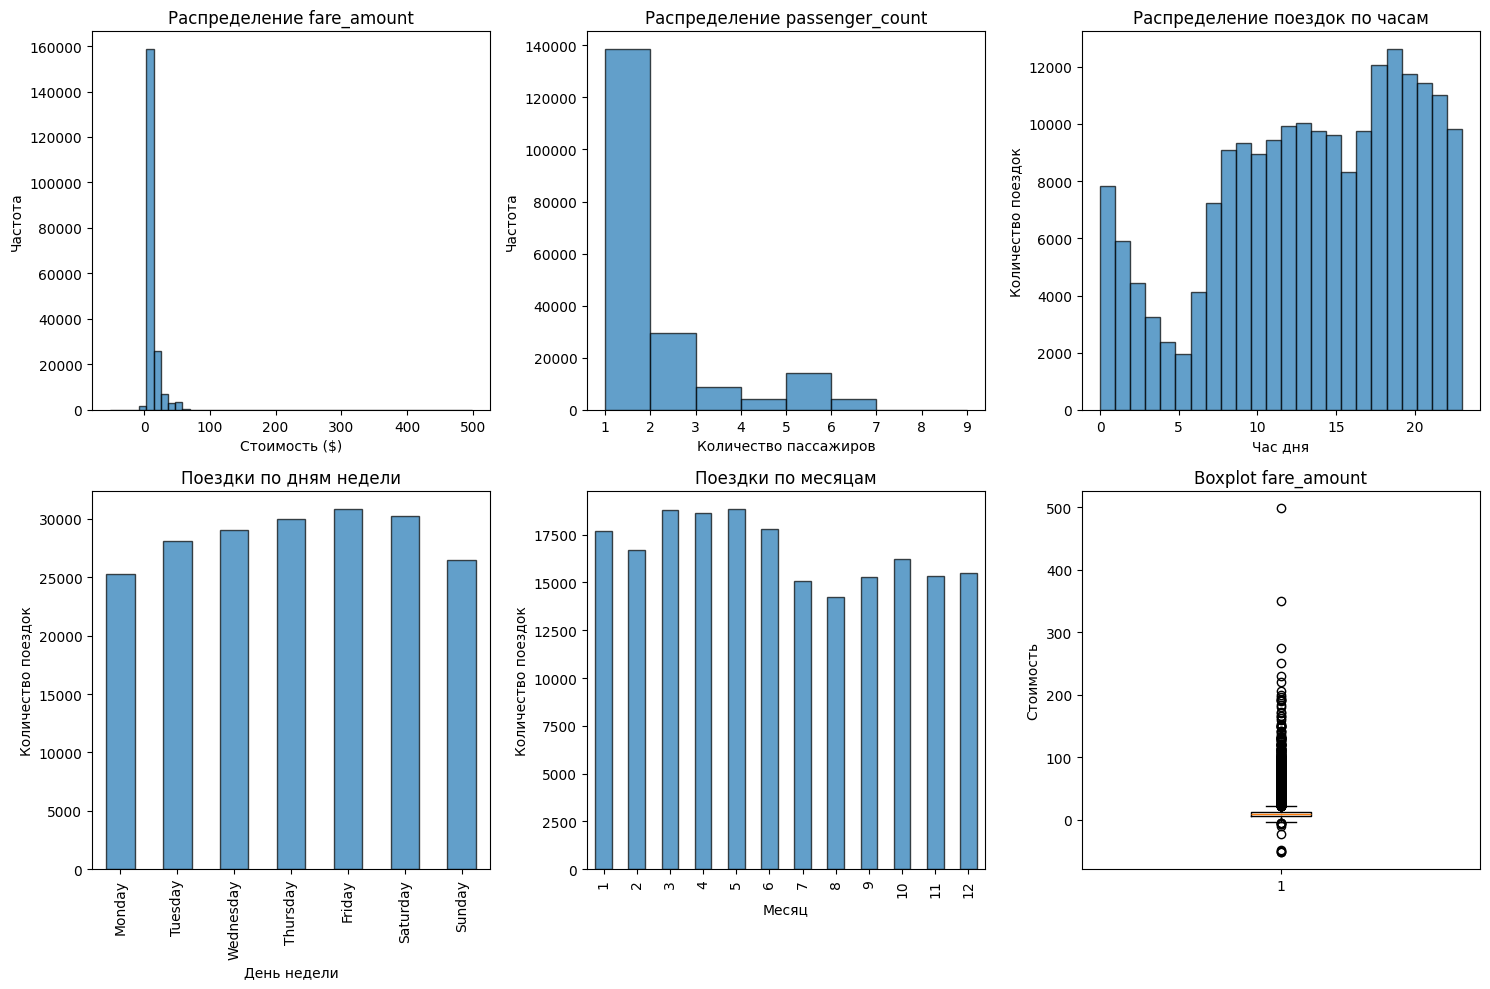

In [43]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10))

# Распределение стоимости поездки
axes[0,0].hist(df_prep['fare_amount'], bins=50, edgecolor='black', alpha=0.7)
axes[0,0].set_title('Распределение fare_amount')
axes[0,0].set_xlabel('Стоимость ($)')
axes[0,0].set_ylabel('Частота')

# Распределение пассажиров
axes[0,1].hist(df_prep['passenger_count'], bins=range(1, 10), edgecolor='black', alpha=0.7)
axes[0,1].set_title('Распределение passenger_count')
axes[0,1].set_xlabel('Количество пассажиров')
axes[0,1].set_ylabel('Частота')

# Время поездок по часам
axes[0,2].hist(df_prep['pickup_hour'], bins=24, edgecolor='black', alpha=0.7)
axes[0,2].set_title('Распределение поездок по часам')
axes[0,2].set_xlabel('Час дня')
axes[0,2].set_ylabel('Количество поездок')

# Дни недели
day_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
df_prep['pickup_day'].value_counts().reindex(day_order).plot(kind='bar', ax=axes[1,0], edgecolor='black', alpha=0.7)
axes[1,0].set_title('Поездки по дням недели')
axes[1,0].set_xlabel('День недели')
axes[1,0].set_ylabel('Количество поездок')

# Месяцы
month_order = range(1, 13)
df_prep['pickup_month'].value_counts().sort_index().plot(kind='bar', ax=axes[1,1], edgecolor='black', alpha=0.7)
axes[1,1].set_title('Поездки по месяцам')
axes[1,1].set_xlabel('Месяц')
axes[1,1].set_ylabel('Количество поездок')

# Boxplot стоимости
axes[1,2].boxplot(df_prep['fare_amount'])
axes[1,2].set_title('Boxplot fare_amount')
axes[1,2].set_ylabel('Стоимость')

plt.tight_layout()
plt.show()

И немного фитуре инжиниринга (расстояние, время дня, сезон)

In [44]:
from math import radians, sin, cos, sqrt, atan2

def haversine_distance(lat1, lon1, lat2, lon2):
    R = 6371  # радиус Земли в км

    lat1, lon1, lat2, lon2 = map(radians, [lat1, lon1, lat2, lon2])

    dlat = lat2 - lat1
    dlon = lon2 - lon1

    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * atan2(sqrt(a), sqrt(1-a))

    return R * c

df_prep['distance_km'] = df_prep.apply(lambda x: haversine_distance(
    x['pickup_latitude'], x['pickup_longitude'],
    x['dropoff_latitude'], x['dropoff_longitude']), axis=1)

df_prep['fare_per_km'] = df_prep['fare_amount'] / df_prep['distance_km'].replace(0, np.nan)

df_prep['pickup_year'] = df_prep['pickup_datetime'].dt.year
df_prep['pickup_dayofyear'] = df_prep['pickup_datetime'].dt.dayofyear

def time_of_day(hour):
    if 5 <= hour < 12:
        return 'Утро'
    elif 12 <= hour < 17:
        return 'День'
    elif 17 <= hour < 22:
        return 'Вечер'
    else:
        return 'Ночь'

df_prep['time_of_day'] = df_prep['pickup_hour'].apply(time_of_day)

def get_season(month):
    if month in [12, 1, 2]:
        return 'Зима'
    elif month in [3, 4, 5]:
        return 'Весна'
    elif month in [6, 7, 8]:
        return 'Лето'
    else:
        return 'Осень'

df_prep['season'] = df_prep['pickup_month'].apply(get_season)

In [45]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 199999 entries, 0 to 199999
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        199999 non-null  float64            
 1   pickup_datetime    199999 non-null  datetime64[ns, UTC]
 2   pickup_longitude   199999 non-null  float64            
 3   pickup_latitude    199999 non-null  float64            
 4   dropoff_longitude  199999 non-null  float64            
 5   dropoff_latitude   199999 non-null  float64            
 6   passenger_count    199999 non-null  int64              
 7   pickup_date        199999 non-null  object             
 8   pickup_hour        199999 non-null  int32              
 9   pickup_day         199999 non-null  object             
 10  pickup_month       199999 non-null  int32              
 11  pickup_weekday     199999 non-null  int32              
 12  distance_km        199999 non-null 

Уберем выбросы

In [46]:
def remove_outliers_by_quantile(df, column, lower_quantile=0.05, upper_quantile=0.95, verbose=True):
    original_len = len(df)

    lower_bound = df[column].quantile(lower_quantile)
    upper_bound = df[column].quantile(upper_quantile)

    if verbose:
        print(f"\n{column.upper()}:")
        print(f"  Границы: [{lower_quantile*100}% = {lower_bound:.2f}, {upper_quantile*100}% = {upper_bound:.2f}]")
        print(f"  Минимум: {df[column].min():.2f}")
        print(f"  Максимум: {df[column].max():.2f}")

        lower_outliers = (df[column] < lower_bound).sum()
        upper_outliers = (df[column] > upper_bound).sum()
        total_outliers = lower_outliers + upper_outliers

        print(f"  Выбросов ниже {lower_quantile*100}%: {lower_outliers} ({lower_outliers/original_len*100:.2f}%)")
        print(f"  Выбросов выше {upper_quantile*100}%: {upper_outliers} ({upper_outliers/original_len*100:.2f}%)")
        print(f"  Всего выбросов: {total_outliers} ({total_outliers/original_len*100:.2f}%)")

    df_filtered = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)].copy()

    if verbose:
        print(f"  Осталось записей: {len(df_filtered)} ({len(df_filtered)/original_len*100:.2f}%)")

    return df_filtered

In [47]:
df_prep = remove_outliers_by_quantile(df_prep, 'fare_amount')
df_prep = remove_outliers_by_quantile(df_prep, 'distance_km')


FARE_AMOUNT:
  Границы: [5.0% = 4.10, 95.0% = 30.33]
  Минимум: -52.00
  Максимум: 499.00
  Выбросов ниже 5.0%: 9155 (4.58%)
  Выбросов выше 95.0%: 9978 (4.99%)
  Всего выбросов: 19133 (9.57%)
  Осталось записей: 180866 (90.43%)

DISTANCE_KM:
  Границы: [5.0% = 0.59, 95.0% = 7.52]
  Минимум: 0.00
  Максимум: 16409.24
  Выбросов ниже 5.0%: 9044 (5.00%)
  Выбросов выше 95.0%: 9044 (5.00%)
  Всего выбросов: 18088 (10.00%)
  Осталось записей: 162778 (90.00%)


количество поездок по дням недели

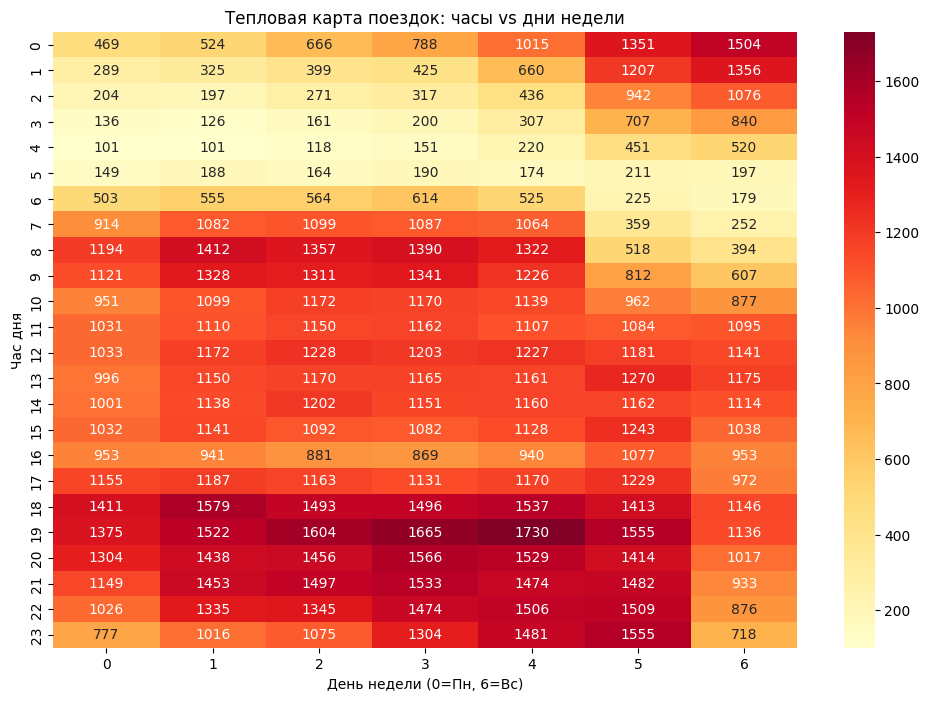

In [48]:
pivot_table = pd.pivot_table(df_prep,
                            values='fare_amount',
                            index='pickup_hour',
                            columns='pickup_weekday',
                            aggfunc='count')

plt.figure(figsize=(12, 8))
sns.heatmap(pivot_table, cmap='YlOrRd', annot=True, fmt='.0f')
plt.title('Тепловая карта поездок: часы vs дни недели')
plt.xlabel('День недели (0=Пн, 6=Вс)')
plt.ylabel('Час дня')
plt.show()

корреляционное исследование

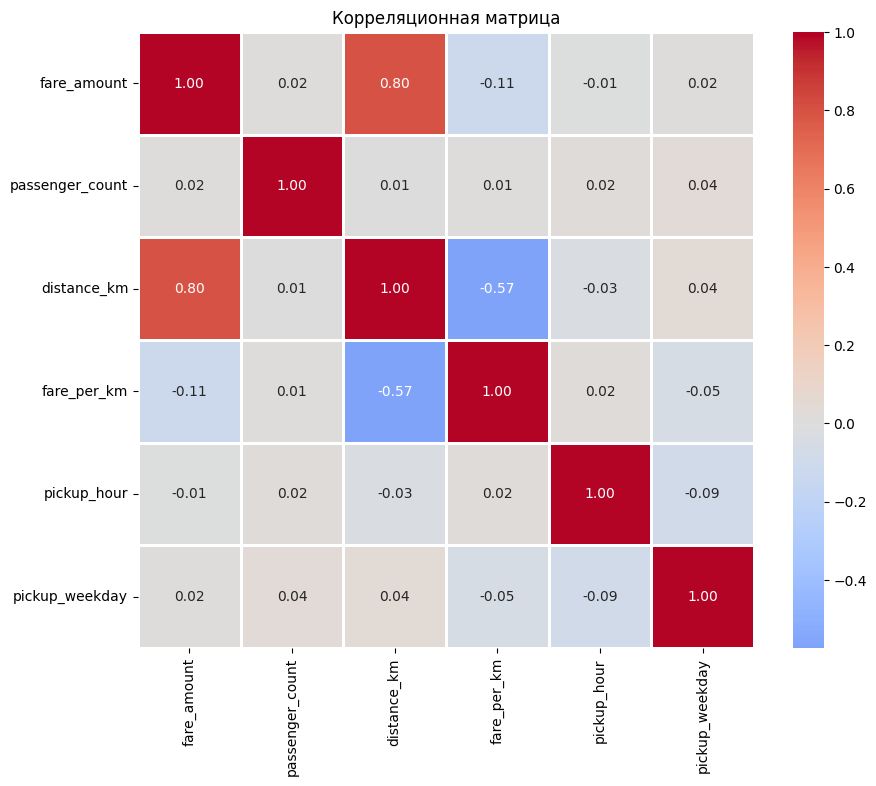

In [49]:
numeric_cols = ['fare_amount', 'passenger_count', 'distance_km',
                'fare_per_km', 'pickup_hour', 'pickup_weekday']

plt.figure(figsize=(10, 8))
corr_matrix = df_prep[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, linewidths=1, fmt='.2f')
plt.title('Корреляционная матрица')
plt.show()

Средние количества поездок

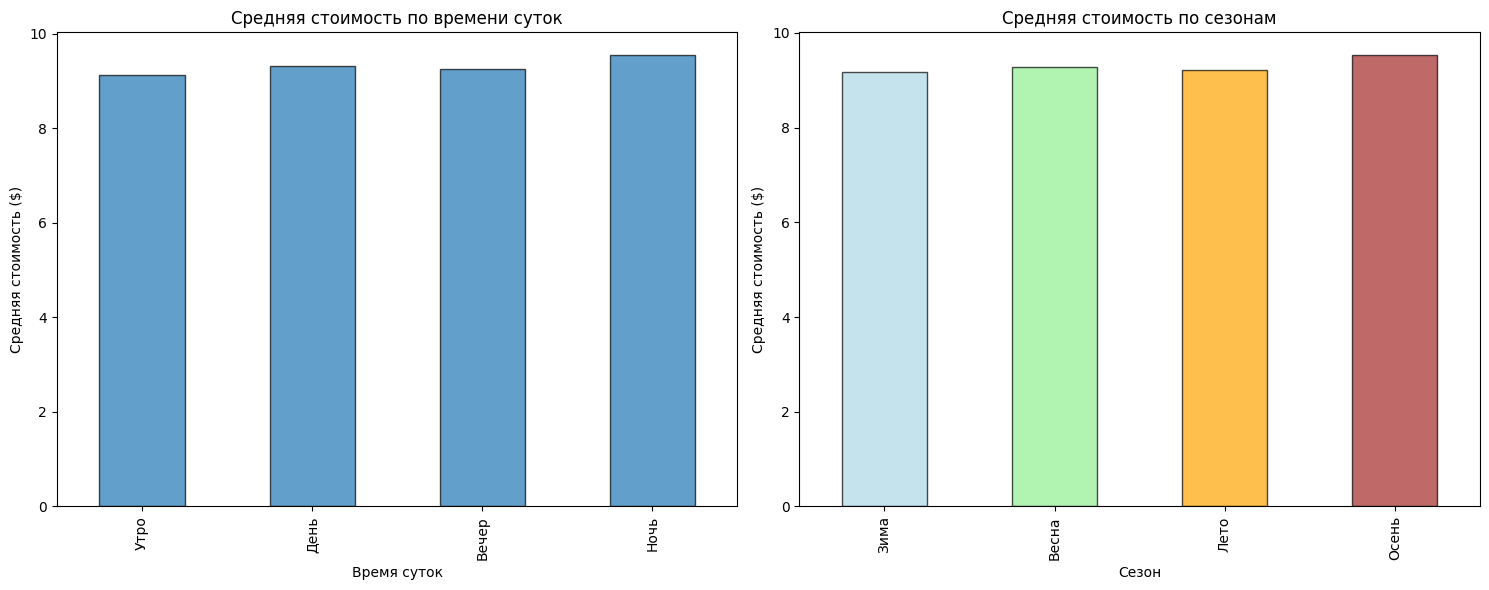

In [50]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

time_order = ['Утро', 'День', 'Вечер', 'Ночь']
df_prep.groupby('time_of_day')['fare_amount'].mean().reindex(time_order).plot(
    kind='bar', ax=axes[0], edgecolor='black', alpha=0.7)
axes[0].set_title('Средняя стоимость по времени суток')
axes[0].set_xlabel('Время суток')
axes[0].set_ylabel('Средняя стоимость ($)')

season_order = ['Зима', 'Весна', 'Лето', 'Осень']
df_prep.groupby('season')['fare_amount'].mean().reindex(season_order).plot(
    kind='bar', ax=axes[1], edgecolor='black', alpha=0.7, color=['lightblue', 'lightgreen', 'orange', 'brown'])
axes[1].set_title('Средняя стоимость по сезонам')
axes[1].set_xlabel('Сезон')
axes[1].set_ylabel('Средняя стоимость ($)')

plt.tight_layout()
plt.show()

In [51]:
df_prep.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162778 entries, 0 to 199999
Data columns (total 18 columns):
 #   Column             Non-Null Count   Dtype              
---  ------             --------------   -----              
 0   fare_amount        162778 non-null  float64            
 1   pickup_datetime    162778 non-null  datetime64[ns, UTC]
 2   pickup_longitude   162778 non-null  float64            
 3   pickup_latitude    162778 non-null  float64            
 4   dropoff_longitude  162778 non-null  float64            
 5   dropoff_latitude   162778 non-null  float64            
 6   passenger_count    162778 non-null  int64              
 7   pickup_date        162778 non-null  object             
 8   pickup_hour        162778 non-null  int32              
 9   pickup_day         162778 non-null  object             
 10  pickup_month       162778 non-null  int32              
 11  pickup_weekday     162778 non-null  int32              
 12  distance_km        162778 non-null 

немного препроцессинга

In [52]:
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer

def prepare_features(df):
    df_processed = df.copy()

    if 'fare_amount' in df_processed.columns:
        y = df_processed['fare_amount']
        df_processed = df_processed.drop('fare_amount', axis=1)
    else:
        y = None

    categorical_cols = ['pickup_day', 'time_of_day', 'season']

    df_processed = pd.get_dummies(df_processed, columns=categorical_cols, drop_first=True)

    numeric_cols = [
        'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
        'dropoff_latitude', 'passenger_count', 'distance_km',
        'fare_per_km'
    ]

    temporal_numeric_cols = ['pickup_hour', 'pickup_month', 'pickup_weekday',
                            'pickup_year', 'pickup_dayofyear']

    all_numeric_cols = numeric_cols + temporal_numeric_cols

    cols_to_scale = [col for col in all_numeric_cols if col in df_processed.columns]

    if cols_to_scale:
        scaler = StandardScaler()
        df_processed[cols_to_scale] = scaler.fit_transform(df_processed[cols_to_scale])

    cols_to_drop = ['pickup_datetime', 'pickup_date']
    existing_cols_to_drop = [col for col in cols_to_drop if col in df_processed.columns]
    df_processed = df_processed.drop(columns=existing_cols_to_drop, errors='ignore')

    return df_processed, y

X, y = prepare_features(df_prep)

print(f"Размерность данных после подготовки: {X.shape}")

Размерность данных после подготовки: (162778, 24)


обучим библиотечное

In [53]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X, y, test_size=0.2, random_state=42
)

tree_reg = RandomForestRegressor()
tree_reg.fit(X_train_reg, y_train_reg)

y_pred_reg = tree_reg.predict(X_test_reg)

print("Regressor Evaluation:")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test_reg, y_pred_reg):.2f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test_reg, y_pred_reg)):.2f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test_reg, y_pred_reg):.2f}")
print(f"R-squared (R2): {r2_score(y_test_reg, y_pred_reg):.2f}")

Regressor Evaluation:
Mean Squared Error (MSE): 0.00
Root Mean Squared Error (RMSE): 0.05
Mean Absolute Error (MAE): 0.01
R-squared (R2): 1.00


обучим кастомную реализацию

In [56]:
X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)

custom_tree = CustomRandomForestRegressor()
custom_tree.fit(X_train_reg.values, y_train_reg.values)

y_pred_custom_reg = custom_tree.predict(X_test_reg.values)

print("Regressor Evaluation:")
print(f"Mean Squared Error (MSE): {mean_squared_error(y_test_reg, y_pred_custom_reg):.2f}")
print(f"Root Mean Squared Error (RMSE): {np.sqrt(mean_squared_error(y_test_reg, y_pred_custom_reg)):.2f}")
print(f"Mean Absolute Error (MAE): {mean_absolute_error(y_test_reg, y_pred_custom_reg):.2f}")
print(f"R-squared (R2): {r2_score(y_test_reg, y_pred_custom_reg):.2f}")

Regressor Evaluation:
Mean Squared Error (MSE): 31.18
Root Mean Squared Error (RMSE): 5.58
Mean Absolute Error (MAE): 2.31
R-squared (R2): 0.70
